# 0. Preparation

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
alphabet = sorted(list(set(''.join(words))))
stoi = {s:i+1 for (i, s) in enumerate(alphabet)}
stoi['.'] = 0
itos = {i:s for (s, i) in stoi.items()}

In [4]:
ALPHABET_SPACE = len(stoi) # 26 letters + 1 special char
NGRAM_SIZE = 3 # number of letters to predict the next letter
REPRESENTATION_DIM = 10 # dim of tensor to represent a label in the alphabet space
HIDDEN_LAYER_NEURON_NUM = 200
MINI_BATCH_SIZE = 32

# 1. Create Data Set

In [5]:
def create_data_set(words, ngram_size: int = 3, test_for_visualization: bool = False):
    X, Y = [], []
    for w in words:
        string = w + '.'
        window = [0] * ngram_size
        for ch in string:
            X.append(window)
            Y.append(stoi[ch])
            window = window[1:] + [stoi[ch]]

    if test_for_visualization:
        [print(''.join(itos[i] for i in prefix), '-->', itos[target]) for (prefix, target) in zip(X[:5], Y[:5])]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


In [245]:
X, Y = create_data_set(words=words, ngram_size=NGRAM_SIZE)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

# 2. Exploration

### 2.1 Embedding

In [75]:
# Use a 2-dimensional tensor to represent each integer in X
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(size=[27, 2], generator=g)

# One hot representation multiplies mapping matrix is just equal to the ith element in that mapping matrix
print(F.one_hot(torch.tensor(5), num_classes=27).float() @ C)
print(C[5])


emb = C[X]
emb.shape

tensor([-0.4713,  0.7868])
tensor([-0.4713,  0.7868])


torch.Size([12, 3, 2])

### 2.2 1st layer

In [76]:
W1 = torch.randn(size=[3*2, 100], generator=g) # [6, 100]
b1 = torch.randn(size=[100], generator=g) # [100, ]
W1.shape, b1.shape


(torch.Size([6, 100]), torch.Size([100]))

### 2.3 2nd layer & loss

In [77]:
hidden = torch.tanh(emb.view(-1, 3 * 2) @ W1 + b1) # [len, 6] * [6, 100] + [100, ] = [len, 100]
print(f"{hidden.shape=}")

W2 = torch.randn(size=[100, 27], generator=g) # [100, 27]
b2 = torch.randn(size=[27], generator=g) # [27,]
logits = hidden @ W2 + b2
print(f"{logits.shape=}")

counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
print(f"{probs.shape=}")

loss = -probs[torch.arange(12), Y].log().mean()
loss


hidden.shape=torch.Size([12, 100])
logits.shape=torch.Size([12, 27])
probs.shape=torch.Size([12, 27])


tensor(20.7275)

### 2.4 PyTorch functions

In [82]:
# Same results
%timeit -r 10 -n 1 naive_reshape = torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :])) # Does not scale for hardcoded index
%timeit -r 10 -n 1 intermediate_reshape = torch.cat(torch.unbind(input=emb, dim=1)) # Scalable, but still creates new tensors which takes space and time
%timeit -r 10 -n 1 advanced_reshape = emb.view(size=[-1, 3 * 2]) # Efficient, no new tensors are created

The slowest run took 27.39 times longer than the fastest. This could mean that an intermediate result is being cached.
84.9 µs ± 113 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)
The slowest run took 27.29 times longer than the fastest. This could mean that an intermediate result is being cached.
21.4 µs ± 44.5 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)
The slowest run took 13.40 times longer than the fastest. This could mean that an intermediate result is being cached.
2.81 µs ± 3.75 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [74]:
# Same results
# Softmax
A = torch.randn(size=[3, 5])
counts = A.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
print(probs)
print(F.softmax(A, dim=1)) # Learning: PyTorch implementations are more numerical stable by substracting the max to avoid overflow, and more efficient by using the mathematical derivative without intermediate variables

# Cross Entropy
B = torch.randint(low=0, high=4, size=[3])
print(-probs[torch.arange(3), B].log().mean()) # Note probs must be softmaxed
print(F.cross_entropy(A, B)) # Learning: Again, prefer PyTorch implementations

tensor([[0.1461, 0.2643, 0.1317, 0.2584, 0.1994],
        [0.3629, 0.3050, 0.0801, 0.1093, 0.1427],
        [0.2853, 0.3179, 0.0723, 0.1629, 0.1617]])
tensor([[0.1461, 0.2643, 0.1317, 0.2584, 0.1994],
        [0.3629, 0.3050, 0.0801, 0.1093, 0.1427],
        [0.2853, 0.3179, 0.0723, 0.1629, 0.1617]])
tensor(1.3956)
tensor(1.3956)


# 3. Build the Network

In [6]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = create_data_set(words=words[:n1], ngram_size=NGRAM_SIZE)
Xval, Yval = create_data_set(words=words[n1:n2], ngram_size=NGRAM_SIZE)
Xtest, Ytest = create_data_set(words=words[n2:], ngram_size=NGRAM_SIZE)

In [7]:
Xtr[0], Xval[0], Xtest[0]

(tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0]))

In [54]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(size=[ALPHABET_SPACE, REPRESENTATION_DIM], generator=g)
W1 = torch.randn(size=[REPRESENTATION_DIM * NGRAM_SIZE, HIDDEN_LAYER_NEURON_NUM], generator=g)
b1 = torch.randn(size=[HIDDEN_LAYER_NEURON_NUM], generator=g)
W2 = torch.randn(size=[HIDDEN_LAYER_NEURON_NUM, ALPHABET_SPACE], generator=g)
b2 = torch.randn(size=[ALPHABET_SPACE], generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [55]:
losses = []

In [56]:
def SGD(X, Y, epochs: int = 1000, learning_rate: float = 0.1, mini_batch_size: int = 32, losses: list=[]):
    for i in range(epochs):
        ix = torch.randint(low=0, high=X.shape[0], size=[mini_batch_size])

        # forward pass
        emb = C[X[ix]]
        hidden = torch.tanh(emb.view(size=[-1, REPRESENTATION_DIM * NGRAM_SIZE]) @ W1 + b1)
        logits = hidden @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix]) 
        losses.append(loss.log10().item())

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # Optimize
        learning_rate = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data += -learning_rate * p.grad

    return loss.item()

### 3.1 Training

In [57]:
# Training
loss = SGD(X=Xtr, Y=Ytr, epochs=200000, learning_rate=0.01, losses=losses, mini_batch_size=MINI_BATCH_SIZE)
print(loss)

2.3835363388061523


200000


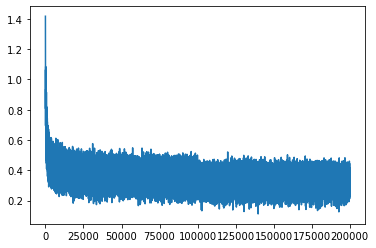

In [58]:
print(len(losses))
plt.plot(range(len(losses)), losses)

### 3.2 Validation

In [48]:
def forward(X, Y):
    emb = C[X]
    hidden = torch.tanh(emb.view(size=[-1, REPRESENTATION_DIM * NGRAM_SIZE]) @ W1 + b1)
    logits = hidden @ W2 + b2
    loss = F.cross_entropy(logits, Y) 
    return loss

In [59]:
print(forward(X=Xtr, Y=Ytr))

print(forward(X=Xval, Y=Yval))

tensor(2.1318, grad_fn=<NllLossBackward0>)
tensor(2.1702, grad_fn=<NllLossBackward0>)


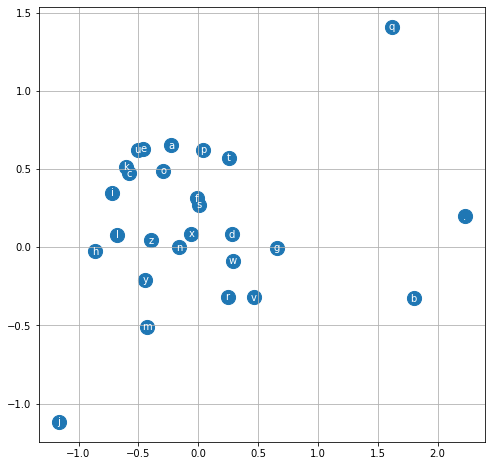

In [60]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")

plt.grid('minor')

# 4. Inference

In [61]:
# Inference
g = torch.Generator().manual_seed(2147483647 + 10)

result = []
for i in range(5):
    charset = []
    ix = 0
    context = [ix] * NGRAM_SIZE # initialize with '...'

    while True:
        emb = C[torch.tensor([context])]
        hidden = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = hidden @ W2 + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(input=probs, num_samples=1, replacement=True, generator=g).item()
        charset.append(itos[ix])
        context = context[1:] + [ix]
        if ix == 0:
            break

    result.append(''.join(charset))
    
print(result)


['noy.', 'harelilan.', 'adrian.', 'eyha.', 'mud.']
